In [4]:
%matplotlib inline
import sys, os, glob, copy, re, shutil

from astropy.io import fits, ascii
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from astropy.table import Table

### Read the light curve files
roe_stars.parquet - Ivezek standard star light curves

wu_qso.parquet - Wu and Shen 2020 SuperCOSMOS light curves

survey_table.fits - Table to map MJD and survey ID to light curve files

See the query.ipynb notebook if you want to see the details of how these were downloaded and constructed.

In [5]:
df_std = pd.read_parquet("roe_stars.parquet")
df_qso = pd.read_parquet("wu_qso.parquet")
df_std.columns = [col.upper() for col in df_std.columns]
df_qso.columns = [col.upper() for col in df_qso.columns]

In [6]:
dat = fits.getdata('survey_table.fits')
t = Table(dat)

# Find columns that are multidimensional and flatten them
for name in t.colnames:
    if len(t[name].shape) > 1 and t[name].shape[1] == 1:
        t[name] = t[name].flatten()

df_survey = t.to_pandas()

In [12]:
# Perform a pandas join (merge) on 'PLATEID'
df_std_merged = pd.merge(df_std, df_survey, on='PLATEID', how='left')
df_qso_merged = pd.merge(df_qso, df_survey, on='PLATEID', how='left')

df_std_merged

,OBJID,SURVEYID,PLATEID,PARENTID,SOURCEID,RA,DEC,SMAG,MJD,NOMINALRA,NOMINALDEC,FIELDID,SURVEYNAME
0,285009734879241,1,66359,285009734879241,285009734879241,0.000127,-0.838752,18.952999,45175.786930,0.000000,0.0,66359.0,SERC-J/EJ
1,566484711575634,2,131895,566484711575634,285009734879241,0.000156,-0.838712,18.309999,48556.498903,0.000000,0.0,66359.0,SERC-R/AAO-R
2,847959688270127,3,197431,847959688270127,285009734879241,0.000083,-0.838790,18.077000,49281.509058,0.000000,0.0,66359.0,SERC-I
3,2536809548522580,9,590143,2536809548522580,285009734879241,0.000119,-0.838656,18.160999,NaN,NaN,NaN,NaN,NaN
4,285009734922687,1,66359,285009734922687,285009734922687,0.000210,0.077200,21.266001,45175.786930,0.000000,0.0,66359.0,SERC-J/EJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619044,285018324881695,1,66361,285018324881673,285018324881695,9.999781,0.950880,18.690001,49655.494481,10.000004,0.0,66361.0,SERC-J/EJ
3619045,566493301593848,2,131897,566493301593822,285018324881695,9.999740,0.950877,17.145000,47467.520372,10.000004,0.0,66361.0,SERC-R/AAO-R
3619046,847968278225969,3,197433,847968278225969,0,9.999487,0.950568,16.087000,45265.568950,10.000004,0.0,66361.0,SERC-I
3619047,847968278225974,3,197433,847968278225969,285018324881695,9.999603,0.950800,16.285999,45265.568950,10.000004,0.0,66361.0,SERC-I


In [13]:
df_qso_merged

,OBJID,SURVEYID,PLATEID,PARENTID,SOURCEID,RA,DEC,SMAG,MJD,NOMINALRA,NOMINALDEC,FIELDID,SURVEYNAME
0,847959688281351,3,197431,847959688281351,285009734896914,0.001819,-0.451121,19.018999,49281.509058,0.000000,0.0,66359.0,SERC-I
1,285009734896914,1,66359,285009734896914,285009734896914,0.002015,-0.451176,21.274000,45175.786930,0.000000,0.0,66359.0,SERC-J/EJ
2,566484711590289,2,131895,566484711590289,285009734896914,0.001949,-0.451143,19.684999,48556.498903,0.000000,0.0,66359.0,SERC-R/AAO-R
3,285009734891787,1,66359,285009734891787,285009734891787,0.006601,-0.559140,21.888000,45175.786930,0.000000,0.0,66359.0,SERC-J/EJ
4,285009734948080,1,66359,285009734948080,285009734948080,0.006698,0.583196,22.641001,45175.786930,0.000000,0.0,66359.0,SERC-J/EJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81684,285018324886571,1,66361,285018324886571,285018324886571,9.991759,1.050093,21.299000,49655.494481,10.000004,0.0,66361.0,SERC-J/EJ
81685,566493301578903,2,131897,566493301578903,566493301578903,9.992899,0.602692,20.742001,47467.520372,10.000004,0.0,66361.0,SERC-R/AAO-R
81686,285018324829523,1,66361,285018324829523,285018324829523,9.992827,-0.230864,21.743000,49655.494481,10.000004,0.0,66361.0,SERC-J/EJ
81687,285018324860528,1,66361,285018324860528,285018324860528,9.995421,0.473056,20.937000,49655.494481,10.000004,0.0,66361.0,SERC-J/EJ


In [48]:
df_qso_merged['SURVEYNAME'].unique()

array(['SERC-I          ', 'SERC-J/EJ       ', 'SERC-R/AAO-R    ', nan],
      dtype=object)

### Match using ra, dec

In [19]:
def match_df(df):
    import numpy as np
    from astropy.coordinates import SkyCoord
    import astropy.units as u

    coords = SkyCoord(df['RA'].to_numpy()*u.deg,
                    df['DEC'].to_numpy()*u.deg)
    i1, i2, _, _ = coords.search_around_sky(coords, 1*u.arcsec)
    m = i1 < i2
    i1 = i1[m]; i2 = i2[m]

    n = len(df)
    parent = np.arange(n)
    rank = np.zeros(n, dtype=int)

    def find(a):
        # path compression
        while parent[a] != a:
            parent[a] = parent[parent[a]]
            a = parent[a]
        return a

    def union(a, b):
        ra, rb = find(a), find(b)
        if ra == rb: return
        if rank[ra] < rank[rb]:
            parent[ra] = rb
        elif rank[ra] > rank[rb]:
            parent[rb] = ra
        else:
            parent[rb] = ra
            rank[ra] += 1

    for a, b in zip(i1, i2):
        union(a, b)

    roots = np.fromiter((find(k) for k in range(n)), dtype=int, count=n)

    # Remap roots to dense 0..K-1 or to min-index per component (shown here)
    import pandas as pd
    tmp = pd.DataFrame({'root': roots, 'idx': np.arange(n)})
    min_idx_map = tmp.groupby('root')['idx'].min()
    df['GROUP_ID'] = min_idx_map.loc[roots].to_numpy()
    return df

In [20]:
df_qso_merged = match_df(df_qso_merged)
df_qso_merged

,OBJID,SURVEYID,PLATEID,PARENTID,SOURCEID,RA,DEC,SMAG,MJD,NOMINALRA,NOMINALDEC,FIELDID,SURVEYNAME,GROUP_ID
0,847959688281351,3,197431,847959688281351,285009734896914,0.001819,-0.451121,19.018999,49281.509058,0.000000,0.0,66359.0,SERC-I,0
1,285009734896914,1,66359,285009734896914,285009734896914,0.002015,-0.451176,21.274000,45175.786930,0.000000,0.0,66359.0,SERC-J/EJ,0
2,566484711590289,2,131895,566484711590289,285009734896914,0.001949,-0.451143,19.684999,48556.498903,0.000000,0.0,66359.0,SERC-R/AAO-R,0
3,285009734891787,1,66359,285009734891787,285009734891787,0.006601,-0.559140,21.888000,45175.786930,0.000000,0.0,66359.0,SERC-J/EJ,3
4,285009734948080,1,66359,285009734948080,285009734948080,0.006698,0.583196,22.641001,45175.786930,0.000000,0.0,66359.0,SERC-J/EJ,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81684,285018324886571,1,66361,285018324886571,285018324886571,9.991759,1.050093,21.299000,49655.494481,10.000004,0.0,66361.0,SERC-J/EJ,81684
81685,566493301578903,2,131897,566493301578903,566493301578903,9.992899,0.602692,20.742001,47467.520372,10.000004,0.0,66361.0,SERC-R/AAO-R,81685
81686,285018324829523,1,66361,285018324829523,285018324829523,9.992827,-0.230864,21.743000,49655.494481,10.000004,0.0,66361.0,SERC-J/EJ,81686
81687,285018324860528,1,66361,285018324860528,285018324860528,9.995421,0.473056,20.937000,49655.494481,10.000004,0.0,66361.0,SERC-J/EJ,81687


In [ ]:
df_std_merged = match_df(df_std_merged)
df_std_merged # ~20 seconds to run

,OBJID,SURVEYID,PLATEID,PARENTID,SOURCEID,RA,DEC,SMAG,MJD,NOMINALRA,NOMINALDEC,FIELDID,SURVEYNAME,GROUP_ID
0,285009734879241,1,66359,285009734879241,285009734879241,0.000127,-0.838752,18.952999,45175.786930,0.000000,0.0,66359.0,SERC-J/EJ,0
1,566484711575634,2,131895,566484711575634,285009734879241,0.000156,-0.838712,18.309999,48556.498903,0.000000,0.0,66359.0,SERC-R/AAO-R,0
2,847959688270127,3,197431,847959688270127,285009734879241,0.000083,-0.838790,18.077000,49281.509058,0.000000,0.0,66359.0,SERC-I,0
3,2536809548522580,9,590143,2536809548522580,285009734879241,0.000119,-0.838656,18.160999,NaN,NaN,NaN,NaN,NaN,0
4,285009734922687,1,66359,285009734922687,285009734922687,0.000210,0.077200,21.266001,45175.786930,0.000000,0.0,66359.0,SERC-J/EJ,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619044,285018324881695,1,66361,285018324881673,285018324881695,9.999781,0.950880,18.690001,49655.494481,10.000004,0.0,66361.0,SERC-J/EJ,3619042
3619045,566493301593848,2,131897,566493301593822,285018324881695,9.999740,0.950877,17.145000,47467.520372,10.000004,0.0,66361.0,SERC-R/AAO-R,3619042
3619046,847968278225969,3,197433,847968278225969,0,9.999487,0.950568,16.087000,45265.568950,10.000004,0.0,66361.0,SERC-I,3619042
3619047,847968278225974,3,197433,847968278225969,285018324881695,9.999603,0.950800,16.285999,45265.568950,10.000004,0.0,66361.0,SERC-I,3619042


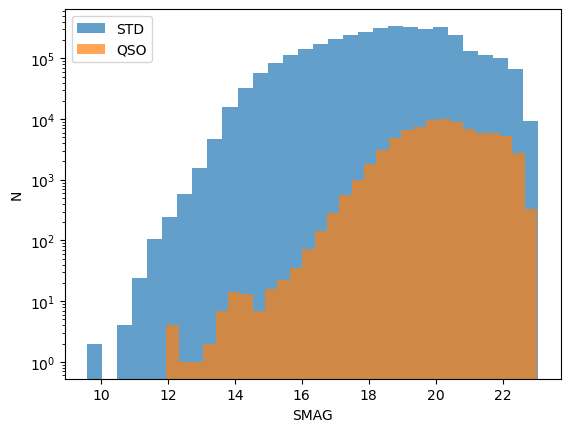

In [28]:
plt.hist(df_std_merged['SMAG'], bins=30, alpha=0.7, label='STD', log=True);
plt.hist(df_qso_merged['SMAG'], bins=30, alpha=0.7, label='QSO', log=True);

plt.xlabel('SMAG');
plt.ylabel('N');
plt.legend();

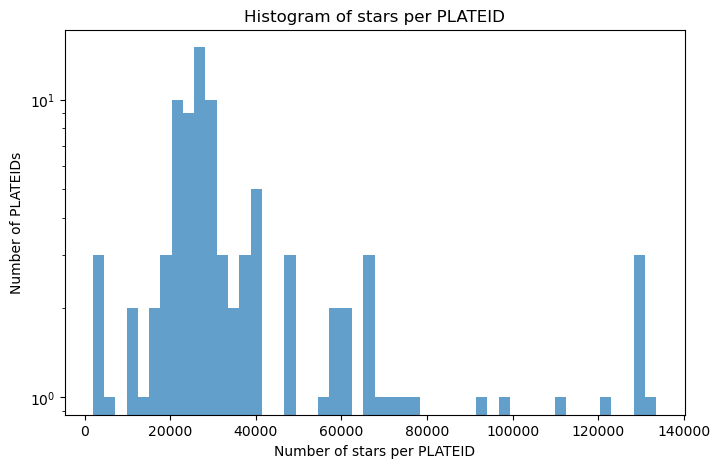

In [49]:
plateid_counts = df_std_merged['PLATEID'].value_counts()

plt.figure(figsize=(8, 5))
plt.hist(plateid_counts, bins=50, log=True, alpha=0.7)
plt.xlabel('Number of stars per PLATEID')
plt.ylabel('Number of PLATEIDs')
plt.title('Histogram of stars per PLATEID')
plt.show()

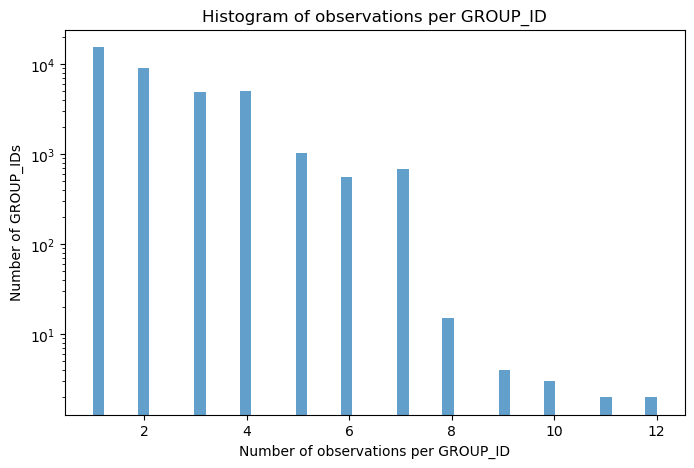

In [41]:
group_counts = df_qso_merged['GROUP_ID'].value_counts()

plt.figure(figsize=(8, 5))
plt.hist(group_counts, bins=50, log=True, alpha=0.7)
plt.xlabel('Number of observations per GROUP_ID')
plt.ylabel('Number of GROUP_IDs')
plt.title('Histogram of observations per GROUP_ID')
plt.show()

### Light curve

The survey ID and band is given by the 'SURVEYNAME' key. Now each object should have a common 'GROUP_ID'.

In [ ]:
def plot_lc(df, group_id):
    import matplotlib.pyplot as plt

    mask_obj = df['GROUP_ID'] == group_id # Plot the ith unique object

    # Use same UPID to join multiple detections
    for j in df[mask_obj]['SURVEYNAME'].unique():
        mask_survey = (df['GROUP_ID'] == group_id) & (df['SURVEYNAME'] == j)
        plt.errorbar(df[mask_survey]['MJD'], df[mask_survey]['SMAG'],
                    linestyle='none', marker='o', alpha=0.5, label=j)

    plt.xlabel('MJD')
    plt.ylabel('SMAG')
    plt.legend(loc='best', fontsize='small')
    plt.gca().invert_yaxis()
    plt.show()

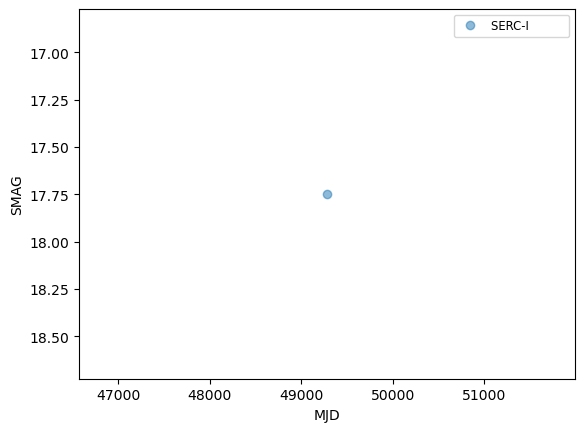

In [ ]:
plot_lc(df_std_merged, df_std_merged['GROUP_ID'].unique()[3]) # Plot the 3rd object's light curve

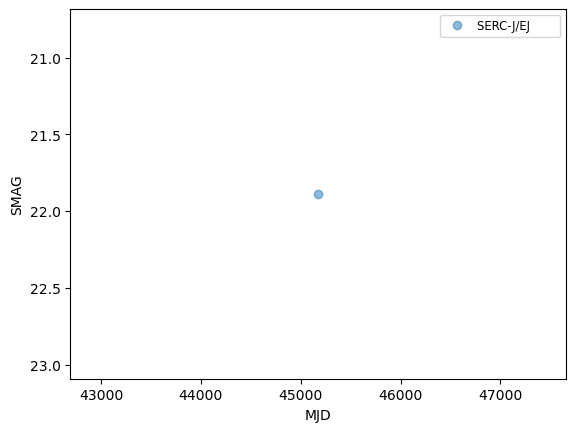

In [45]:
plot_lc(df_qso_merged, df_qso_merged['GROUP_ID'].unique()[1])